# Understanding Dataset Air Flight Status**


In [1]:
#installing pyspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=4305ea36465b5aeb5bc466868f27222012f621b8920e3231ddfecb11de405aa7
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
#creating a spark session
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("FlightPrediction").getOrCreate()

In [4]:
#loading the first dataset combined flights
flights_df = spark.read.csv('Combined_Flights_2022.csv',inferSchema=True, header =True)

In [5]:
#loading the second dataset airlines
airlines = spark.read.csv('Airlines.csv',inferSchema=True, header =True)

In [6]:
#showing the first 20 rows of the flights dataframe
flights_df.show()

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+-------------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|De

In [7]:
#creating a temporary view of the flights dataframe
flights_df.createOrReplaceTempView("Flights")

In [8]:
# creating a temporary view of the airlines dataframe
airlines.createOrReplaceTempView("Airlines")

In [9]:
#checking the schema
airlines.printSchema()

root
 |-- Code: string (nullable = true)
 |-- Description: string (nullable = true)



In [10]:
#checking the schema
flights_df.printSchema()

root
 |-- FlightDate: date (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |

In [11]:
#checking the dimensions
flights_df.count()

472349

# **Analysis using Spark SQL**

**1st Query:  Longest Average Flight Distance by Airline**


*   This SQL query is conducted on the two datasets that we have "Comibined_Flights_2022" and "Airlines" involving a join operation based on the common column "Airline."
*    The query retrieves information about various airlines, aggregating the total number of flights and the average arrival delay for each airline.
*   The result is then sorted in descending order based on the total number of flights.
*    This information provides a concise overview of the flight data, highlighting key performance indicators for each airline, such as their operational scale and average arrival delay.
*   Notably, airlines like JetBlue Airways, Allegiant Air, and  Frontier Airlines are prominent in terms of the total number of flights, with corresponding average arrival delay times.





In [12]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
#running the query
sqlDF = spark.sql("""
SELECT
    Airlines.Description AS Airline,
    COUNT(*) AS TotalFlights,
    AVG(Flights.ArrDelayMinutes) AS AverageArrivalDelay
FROM
    Flights
INNER JOIN
    Airlines ON Flights.Airline = Airlines.Description
GROUP BY
    Airlines.Description
ORDER BY
    AverageArrivalDelay DESC LIMIT 5
""")

# Showing the results
sqlDF.show()


+--------------------+------------+-------------------+
|             Airline|TotalFlights|AverageArrivalDelay|
+--------------------+------------+-------------------+
|     JetBlue Airways|       24141|  36.86117453648735|
|Frontier Airlines...|       12203|   30.0911799761621|
|       Allegiant Air|       10542| 27.005776385353435|
|    Spirit Air Lines|       18653|  26.76246105919003|
|Southwest Airline...|      102931| 16.004396455047985|
+--------------------+------------+-------------------+



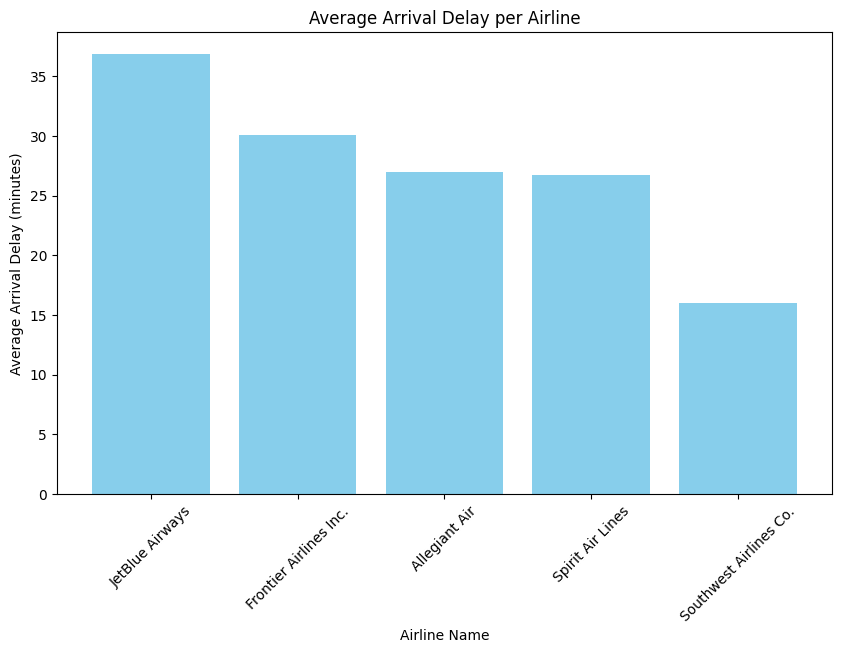

In [14]:
#showing the visualisation of the results
import matplotlib.pyplot as plt
pandas_df = sqlDF.toPandas()
plt.figure(figsize=(10,6))
plt.bar(pandas_df['Airline'], pandas_df['AverageArrivalDelay'], color='skyblue')
plt.xlabel('Airline Name')
plt.ylabel('Average Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.title('Average Arrival Delay per Airline')
plt.show()

 **2nd Query: Top 5 Airlines with the most Cancelled flights**



*   This Spark SQL query analyzes flight data to determine the top 5 airlines with the highest percentage of cancelled flights.

*   The CancelledFlights column counts the number of cancelled flights for each airline, and TotalFlights counts the overall number of flights. The CancelledPercentage is calculated as the ratio of cancelled flights to total flights, presented as a percentage.
*    The result set shows Gojet Airlines as the airline with the highest cancellation rate at approximately 6.6%, followed by JetBlues Airways, Spirit Air Lines, Republic Airlines and Envoy Airlines .
*   The percentage is computed by dividing the number of cancelled flights by the total number of flights and multiplying by 100.







In [ ]:
#running the query
sqlDF = spark.sql("""SELECT Airline AS OpAirline,
        COUNT(CASE WHEN Cancelled = true THEN 1 END) AS CancelledFlights,
        COUNT(*) AS TotalFlights,
        (COUNT(CASE WHEN Cancelled = true THEN 1 END) / COUNT(*)) * 100 AS CancelledPercentage
    FROM
        Flights
    GROUP BY
        Airline
    ORDER BY
        CancelledPercentage DESC
    LIMIT 5""");
#showing the results
sqlDF.show()

+--------------------+----------------+------------+-------------------+
|           OpAirline|CancelledFlights|TotalFlights|CancelledPercentage|
+--------------------+----------------+------------+-------------------+
|GoJet Airlines, L...|             900|       14034|  6.412997007268063|
|     JetBlue Airways|            3626|       67587|  5.364937044106115|
|    Spirit Air Lines|            2547|       54774|  4.650016431153467|
|American Airlines...|            9160|      208658|  4.389958688380029|
|   Republic Airlines|            3302|       81314|  4.060801338022973|
+--------------------+----------------+------------+-------------------+



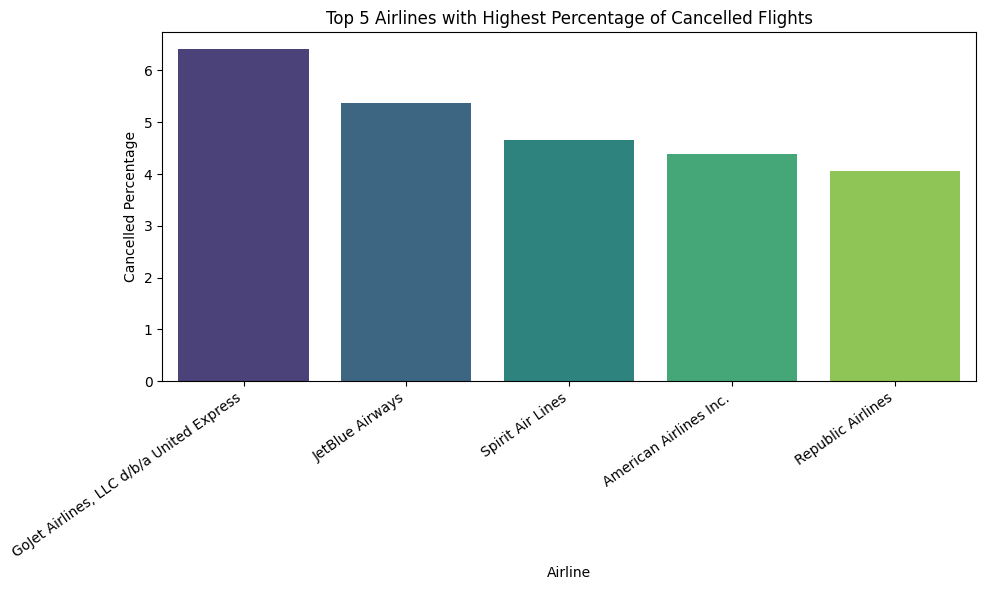

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#showing the visualisation of the results
pandas_df = sqlDF.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='OpAirline', y='CancelledPercentage', data=pandas_df, palette='viridis')
plt.xlabel('Airline')
plt.ylabel('Cancelled Percentage')
plt.title('Top 5 Airlines with Highest Percentage of Cancelled Flights')
plt.xticks(rotation=35, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

**3rd Query: The percentage of on-time flights for each airline, show the top 5.**

*   This Spark SQL query evaluates airline punctuality by calculating on-time performance based on the 'DepDel15' column.

*   The result includes the total number of flights, the count of on-time flights, delayed flights, and the on-time percentage for the top 5 airlines.
*   Capital Cargo International leads with an on-time percentage of around 85%, followed by Horizon Air, Hawaiian Airlines, SkyWest Airlines, and Air Wisconsin Airlines.
*   Skywest Airlines, despite having the highest total flights, exhibits a comparatively lower on-time performance.
*   The on-time percentage is computed as the ratio of on-time flights to total flights, presented as a percentage.


In [ ]:
#running the query
sqlDF = spark.sql("""SELECT Airline,
           COUNT(*) AS TotalFlights,
           SUM(CASE WHEN DepDel15 = 0 THEN 1 ELSE 0 END) AS OnTimeFlights,
           SUM(CASE WHEN DepDel15 = 1 THEN 1 ELSE 0 END) AS DelayedFlights,
           (SUM(CASE WHEN DepDel15 = 0 THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS OnTimePercentage
    FROM Flights
    GROUP BY Airline
    ORDER BY OnTimePercentage DESC LIMIT 5
""");
#showing the results
sqlDF.show()

+--------------------+------------+-------------+--------------+-----------------+
|             Airline|TotalFlights|OnTimeFlights|DelayedFlights| OnTimePercentage|
+--------------------+------------+-------------+--------------+-----------------+
|Capital Cargo Int...|       22433|        19266|          2704|  85.882405384924|
|         Horizon Air|       23273|        19933|          3068|85.64860568040218|
|Hawaiian Airlines...|       17757|        14870|          2789|83.74162302190685|
|SkyWest Airlines ...|      245662|       204452|         37346|83.22491879085898|
|Air Wisconsin Air...|       16626|        13703|          2264| 82.4191026103693|
+--------------------+------------+-------------+--------------+-----------------+



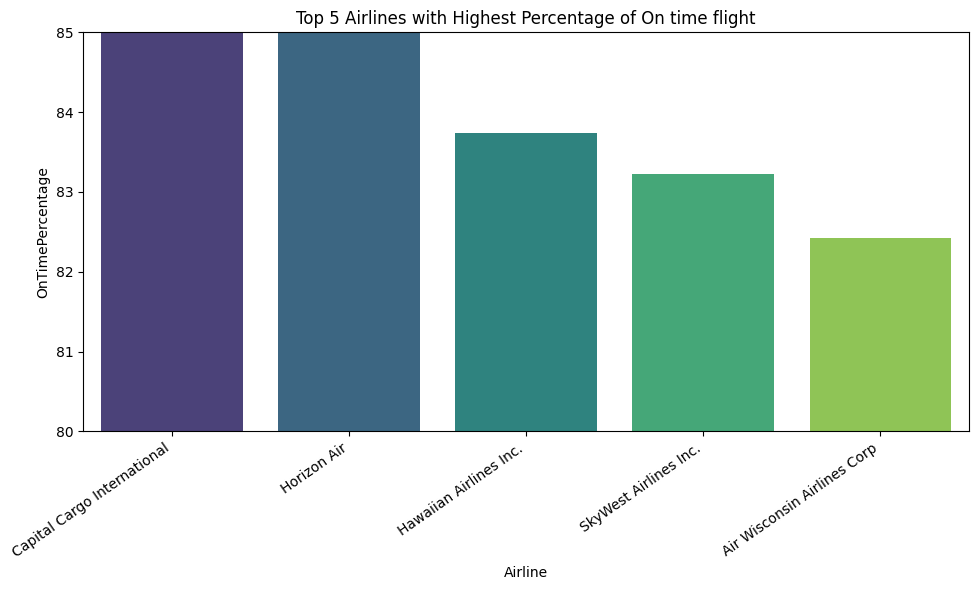

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#showing the visualisation of the results
pandas_df = sqlDF.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Airline', y='OnTimePercentage', data=pandas_df, palette='viridis')
plt.xlabel('Airline')
plt.ylabel('OnTimePercentage')
plt.title('Top 5 Airlines with Highest Percentage of On time flight')
plt.xticks(rotation=35, ha='right')
plt.ylim(80)
plt.tight_layout()
plt.show()

**4th Query: Top 5 Airlines with the Highest Average Departure Delay**


*   This Spark SQL query focuses on assessing the average
departure delay for different airlines.
*  The AVG(DepDelay) column calculates the average departure delay for each airline, excluding null values.
*   The result is then ordered by the average departure delay in descending order, presenting the top 5 airlines.
*   Jet Blue Airways leads with an average departure delay of 28.46 minutes, followed by Allegiant Airlines, Frontier Airlines, Spirit Air lines, and American Airlines.
*   The query provides insights into the airlines with the highest average departure delays, offering valuable information for understanding and addressing punctuality issues within the aviation industry.


In [ ]:
#running the query
sqlDF = spark.sql ("""SELECT Airline, AVG(DepDelay) AS AvgDepartureDelay
                      FROM Flights WHERE DepDelay IS NOT NULL
                      GROUP BY Airline ORDER BY AvgDepartureDelay
                      DESC LIMIT 5;""")
#showing the results
sqlDF.show()

+--------------------+------------------+
|             Airline| AvgDepartureDelay|
+--------------------+------------------+
|Southwest Airline...|16.703808194498066|
|GoJet Airlines, L...|12.114213197969542|
|Commutair Aka Cha...|              11.0|
|  Mesa Airlines Inc.| 8.873173582700176|
|   Republic Airlines| 5.158715012722646|
+--------------------+------------------+



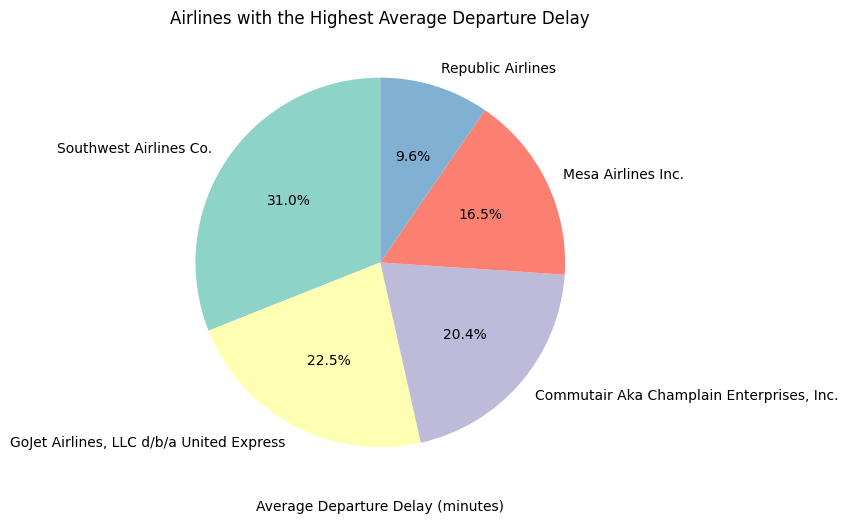

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


pandas_df = sqlDF.toPandas()

# Creating a figure and axis
plt.figure(figsize=(12, 6))

# Using a seaborn color palette for the pie chart
colors = sns.color_palette('Set3', n_colors=len(pandas_df))

# Plot a pie chart with airlines and their average departure delays
plt.pie(pandas_df['AvgDepartureDelay'], labels=pandas_df['Airline'], autopct='%1.1f%%', colors=colors, startangle=90)

# Set axis labels and title
plt.xlabel('Average Departure Delay (minutes)')
plt.title('Airlines with the Highest Average Departure Delay')

# Display the pie chart
plt.show()

**5th Query:Top 5 Routes with the Longest Average Airtime**


*   This Spark SQL query analyzes flight data to determine the top 5 city pairs with the longest average airtime.
*   The AVG(AirTime) column calculates the average duration of flights for each unique combination of origin and destination cities.
*   The result is ordered by the average airtime in descending order, presenting the city pairs with the lengthiest average flight times.
*   The displayed results show the origin and destination city names along with their corresponding average airtime, revealing the top 5 city pairs with the lengthiest flight durations.
*   In the example provided, flights originating from Boston, MA, to Honolulu, HI, exhibit the highest average airtime, followed by flights from New York, NY, to Honolulu, HI, and other city pairs in descending order.

In [ ]:
#running the query
sqlDF = spark.sql ("""SELECT OriginCityName, DestCityName, AVG(AirTime) AS AvgAirTime
                    FROM Flights GROUP BY OriginCityName, DestCityName
                    ORDER BY AvgAirTime
                    DESC LIMIT 10;""")
#showing the results
sqlDF.show()

+--------------+------------+------------------+
|OriginCityName|DestCityName|        AvgAirTime|
+--------------+------------+------------------+
|   Phoenix, AZ|   Lihue, HI| 388.0769230769231|
|   Phoenix, AZ|Honolulu, HI| 377.9032258064516|
|   Phoenix, AZ|    Kona, HI|          375.5625|
| Las Vegas, NV|   Lihue, HI| 374.4117647058824|
|   Phoenix, AZ| Kahului, HI|372.51724137931035|
| Las Vegas, NV|Honolulu, HI|          359.6875|
| Las Vegas, NV|    Kona, HI|             359.0|
| Las Vegas, NV| Kahului, HI|             355.3|
| San Diego, CA|   Lihue, HI| 353.8888888888889|
| San Diego, CA|    Kona, HI| 343.7142857142857|
+--------------+------------+------------------+



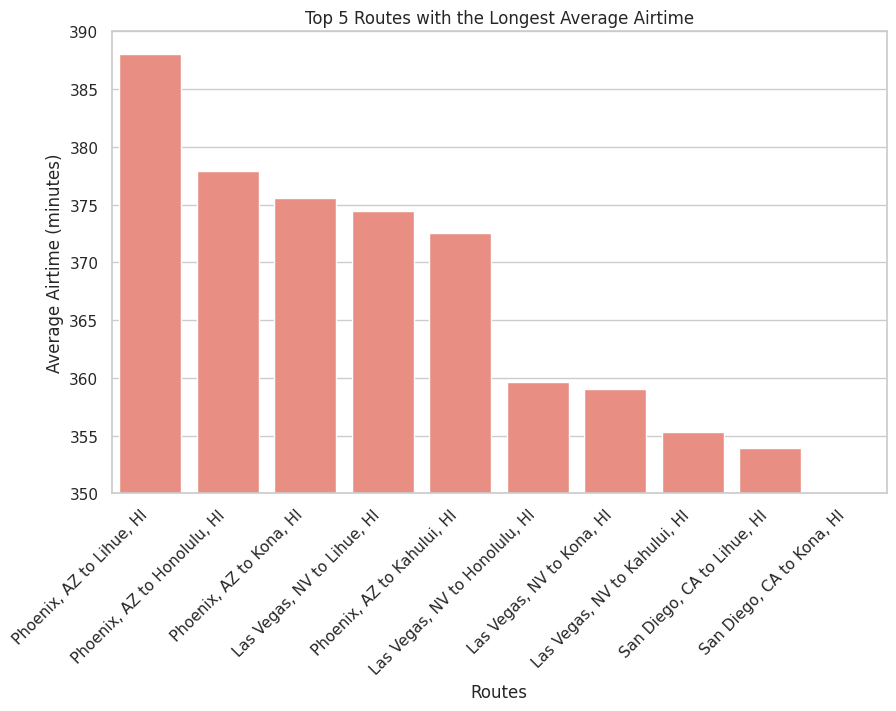

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


pandas_df = sqlDF.toPandas()

# Combine 'OriginCityName' and 'DestCityName' to create route labels
pandas_df['Route'] = pandas_df['OriginCityName'] + ' to ' + pandas_df['DestCityName']

# Create a figure and axis using seaborn's style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Use a seaborn bar plot with confidence intervals
sns.barplot(x='Route', y='AvgAirTime', data=pandas_df, color='salmon')

# Customize the plot
plt.xlabel('Routes')
plt.ylabel('Average Airtime (minutes)')
plt.title('Top 5 Routes with the Longest Average Airtime')
plt.xticks(rotation=45, ha='right')
plt.ylim(350,390)

# Display the plot
plt.show()


**6th query: Top 5 flights with the most time spent in plane that never departed**



*   This Spark SQL query focuses on retrieving flight information for cancelled flights where the taxi-out time is not null.
*   The selected columns include the flight date, airline, origin city, destination city, taxi-out time, and a flag indicating cancellation.
*  The results are ordered by taxi-out time in descending order, providing insights into the longest taxi-out times for cancelled flights.
*   one instance involves an Skywest Airlines flight from Pueblo, CO, to D, CO, on April 13, 2022, with a substantial taxi-out time of 102 minutes before cancellation.
*   Similar scenarios are observed in the other showcased results, emphasizing the diversity in taxi-out durations for cancelled flights.


+----------+--------------------+--------------------+----------------+-------+---------+
|FlightDate|             Airline|      OriginCityName|    DestCityName|TaxiOut|Cancelled|
+----------+--------------------+--------------------+----------------+-------+---------+
|2022-05-29|SkyWest Airlines ...|          Pueblo, CO|      Denver, CO|  124.0|     true|
|2022-05-22|United Air Lines ...|          Boston, MA|      Newark, NJ|  116.0|     true|
|2022-04-13|           Envoy Air|Dallas/Fort Worth...|Myrtle Beach, SC|  102.0|     true|
|2022-07-25|   Republic Airlines|          Newark, NJ|  Pittsburgh, PA|   87.0|     true|
|2022-04-07|           Envoy Air|           Tampa, FL|   Nashville, TN|   82.0|     true|
+----------+--------------------+--------------------+----------------+-------+---------+



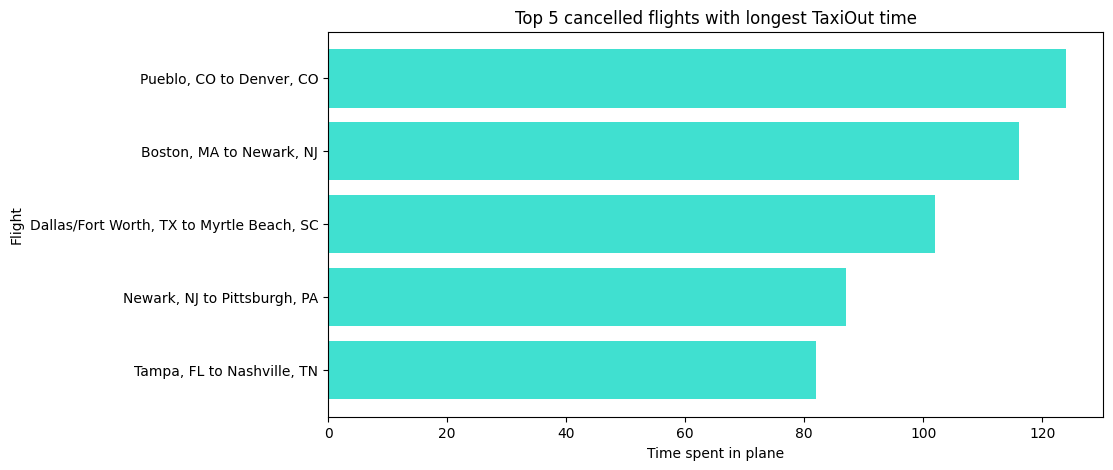

In [ ]:
#running the query
sqlDF = spark.sql("""
SELECT
    FlightDate,
    Airline,
    OriginCityName,
    DestCityName,
    TaxiOut,
    Cancelled

FROM
    Flights
WHERE
    Cancelled = 1 AND TaxiOut IS NOT NULL
ORDER BY
    TaxiOut DESC
LIMIT 5
""")
#showing the results
sqlDF.show()
# visualisation of the results
pandas_df = sqlDF.toPandas()

pandas_df['FlightLabel'] = pandas_df['OriginCityName'] + " to " + pandas_df['DestCityName']

plt.figure(figsize=(10, 5))
plt.barh(pandas_df['FlightLabel'], pandas_df['TaxiOut'], color='Turquoise')

plt.xlabel('Time spent in plane')
plt.ylabel('Flight')
plt.title('Top 5 cancelled flights with longest TaxiOut time')
plt.gca().invert_yaxis()

plt.show()

**7th Query: Flights with Longest Delays Despite On-time Departure**



*   This Spark SQL query extracts flight information for cases where departure delays are zero or negative (DepDelay <= 0) and arrival delays exceed 30 minutes (ArrDelay > 30).
*   The selected columns include the flight number, flight date, airline, origin city, destination city, departure delay, arrival delay, and airtime.
*   The results are then ordered by arrival delay in descending order, presenting the top 5 instances.Examining the results in detail, some notable instances include Endeavor Air Inc. flights from Myrtle Beach, SC, and Milwaukee, WI, which, despite having negative departure delays, encountered notable arrival delays of 200 and 166 minutes, respectively.
*   This analysis provides valuable information for identifying patterns and anomalies in flight operations, contributing to a deeper understanding of the dataset.






+-------------------------------+----------+--------------------+----------------+--------------------+--------+--------+-------+
|Flight_Number_Marketing_Airline|FlightDate|             Airline|  OriginCityName|        DestCityName|DepDelay|ArrDelay|AirTime|
+-------------------------------+----------+--------------------+----------------+--------------------+--------+--------+-------+
|                           1990|2022-05-16|United Air Lines ...| Los Angeles, CA|          Newark, NJ|    -3.0|   204.0|  328.0|
|                           5334|2022-07-21|   Endeavor Air Inc.|Myrtle Beach, SC|        New York, NY|    -5.0|   200.0|  112.0|
|                           2191|2022-05-16|United Air Lines ...|       Miami, FL|          Newark, NJ|    -5.0|   196.0|  177.0|
|                           2407|2022-05-20|United Air Lines ...|     Chicago, IL| Fort Lauderdale, FL|    -6.0|   182.0|  165.0|
|                           4711|2022-07-05|   Republic Airlines|    New York, NY|Greensbo

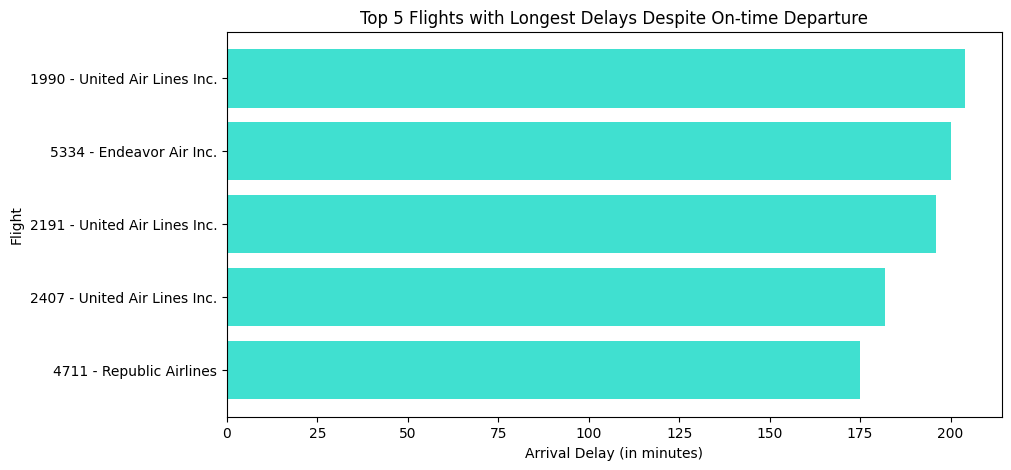

In [ ]:
#running the query
sqlDF = spark.sql("""
SELECT Flight_Number_Marketing_Airline, FlightDate, Airline, OriginCityName, DestCityName, DepDelay, ArrDelay, AirTime
FROM Flights
WHERE DepDelay <= 0 AND ArrDelay > 30
ORDER BY ArrDelay DESC
LIMIT 5;
""")
#showing the results
sqlDF.show()

pandasDF = sqlDF.toPandas()

pandasDF['Flight_Number_Marketing_Airline'] = pandasDF['Flight_Number_Marketing_Airline'].astype(str)

plt.figure(figsize=(10, 5))
plt.barh(pandasDF['Flight_Number_Marketing_Airline'] + " - " + pandasDF['Airline'], pandasDF['ArrDelay'], color='green')
plt.xlabel('Arrival Delay (in minutes)')
plt.ylabel('Flight')
plt.title('Top 5 Flights with Longest Delays Despite On-time Departure')
plt.gca().invert_yaxis()
plt.show()


**8th Query: Top 5 airlines with over 100 filights, high average departure delay and early arrivals**



*   In this query, we are focusing on the efficiency of airlines in managing flight delays.
*   this SQL query specifically targets flights that weren't cancelled or diverted yet experienced some departure delays. Considering also flights that managed to arrive on time or even earlier than scheduled despite the initial delay.
*  By calculating the average departure and arrival delays for each airline and then filtering to include only those airlines with a substantial number of flights (over 100) we're ensuring our analysis is both relevant and reliable. Our query then sorts these airlines to identify the top five with the highest average departure delays.
*   This insight is particularly crucial as it highlights which airlines are effectively minimizing the impact of departure delays on arrival times, a key indicator of operational efficiency and passenger satisfaction.






+--------------------+-----------------+-------------------+
|             Airline|AvgDepartureDelay|    AvgArrivalDelay|
+--------------------+-----------------+-------------------+
|     JetBlue Airways|8.294400963275136|-10.172636965683322|
|Frontier Airlines...|7.403965785381026| -7.628304821150856|
|   Republic Airlines|6.907060333761232| -7.813607188703466|
|United Air Lines ...|6.838954108858058| -9.097082888651725|
|Capital Cargo Int...|6.805510534846029|  -6.06807131280389|
+--------------------+-----------------+-------------------+



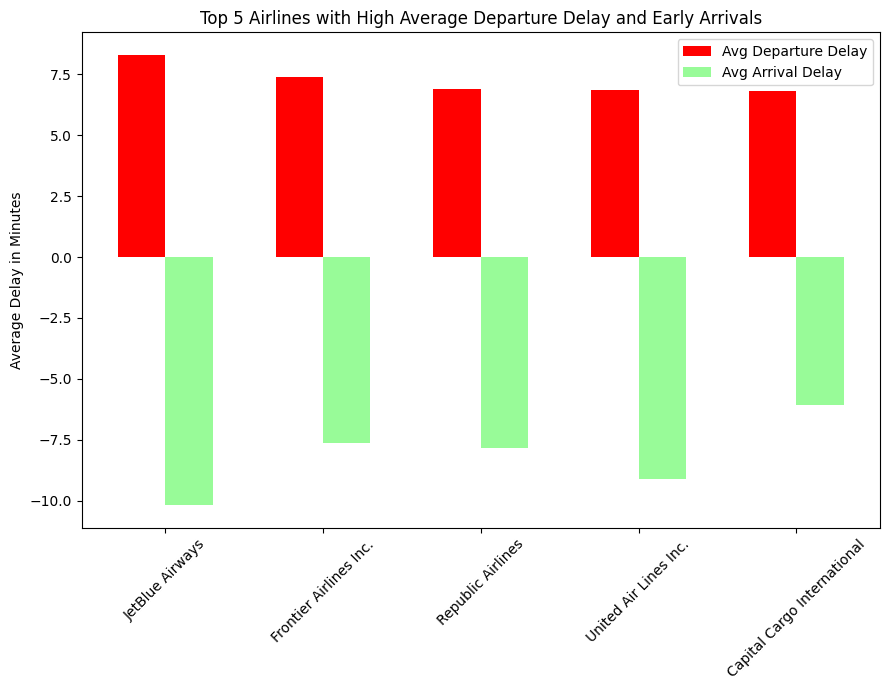

In [ ]:
#running the query
sqlDF = spark.sql("""
SELECT
    Airline,
    AVG(DepDelay) AS AvgDepartureDelay,
    AVG(ArrDelay) AS AvgArrivalDelay
FROM
    Flights
WHERE
    Cancelled = false AND Diverted = false AND DepDelay > 0 AND ArrDelay <= 0
GROUP BY
    Airline
HAVING
    COUNT(*) > 100
ORDER BY
    AvgDepartureDelay DESC
LIMIT 5
""")
#showing the results
sqlDF.show()


pandasDF = sqlDF.toPandas()

pandasDF.set_index('Airline', inplace=True)

fig, ax = plt.subplots(figsize=(9, 7))

pos = list(range(len(pandasDF['AvgDepartureDelay'])))
width = 0.3

plt.bar(pos, pandasDF['AvgDepartureDelay'], width, color='red', label='Avg Departure Delay')
plt.bar([p + width for p in pos], pandasDF['AvgArrivalDelay'], width, color='palegreen', label='Avg Arrival Delay')

ax.set_ylabel('Average Delay in Minutes')
ax.set_title('Top 5 Airlines with High Average Departure Delay and Early Arrivals')
ax.set_xticks([p + width/2 for p in pos])
ax.set_xticklabels(pandasDF.index, rotation=45)
plt.legend(['Avg Departure Delay', 'Avg Arrival Delay'], loc='upper right')

plt.tight_layout()
plt.show()


# **Machine Learning using Spark MLlib**

#**PRE PROCESSING**

In [ ]:
#importing the necessary libraries
from pyspark.ml.feature import VectorAssembler, StandardScaler, Imputer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import precision_recall_curve, auc, accuracy_score
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from pyspark.sql.functions import isnan
from pyspark.sql.functions import count
from pyspark.sql.types import DateType
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
import numpy as np
from pyspark.sql.types import StringType
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix


# **Data cleaning**

In [ ]:
#covert boolean to integer
flights_df = flights_df.withColumn("Cancelled", col("Cancelled").cast("integer"))
flights_df = flights_df.withColumn("Diverted", col("Diverted").cast("integer"))

In [ ]:
#checking the null values
flights_df.select([count(when(col(c).isNull(), c)).alias(c) for c in flights_df.columns]).show()

+----------+-------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime|

In [ ]:
flights_df=flights_df.withColumn("DepTime",when(flights_df.DepTime==0,np.nan).otherwise (flights_df.DepTime))
flights_df=flights_df.withColumn("DepDelayMinutes",when(flights_df.DepDelayMinutes==0,np.nan).otherwise (flights_df.DepDelayMinutes))
flights_df=flights_df.withColumn("DepDelay",when(flights_df.DepDelay==0,np.nan).otherwise (flights_df.DepDelay))
flights_df=flights_df.withColumn("ArrTime",when(flights_df.ArrTime==0,np.nan).otherwise (flights_df.ArrTime))
flights_df=flights_df.withColumn("Distance",when(flights_df.Distance==0,np.nan).otherwise (flights_df.Distance))
flights_df=flights_df.withColumn("ArrDelayMinutes",when(flights_df.ArrDelayMinutes==0,np.nan).otherwise (flights_df.ArrDelayMinutes))
flights_df=flights_df.withColumn("AirTime",when(flights_df.AirTime==0,np.nan).otherwise (flights_df.AirTime))
flights_df=flights_df.withColumn("ActualElapsedTime",when(flights_df.ActualElapsedTime==0,np.nan).otherwise (flights_df.ActualElapsedTime))
flights_df=flights_df.withColumn("Tail_Number",when(flights_df.Tail_Number==0,np.nan).otherwise (flights_df.Tail_Number))
flights_df=flights_df.withColumn("DepDel15",when(flights_df.DepDel15==0,np.nan).otherwise (flights_df.DepDel15))
flights_df=flights_df.withColumn("DepartureDelayGroups",when(flights_df.DepartureDelayGroups==0,np.nan).otherwise (flights_df.DepartureDelayGroups))
flights_df=flights_df.withColumn("TaxiOut",when(flights_df.TaxiOut==0,np.nan).otherwise (flights_df.TaxiOut))
flights_df=flights_df.withColumn("WheelsOff",when(flights_df.WheelsOff==0,np.nan).otherwise (flights_df.WheelsOff))
flights_df=flights_df.withColumn("WheelsOn",when(flights_df.WheelsOn==0,np.nan).otherwise (flights_df.WheelsOn))
flights_df=flights_df.withColumn("TaxiIn",when(flights_df.TaxiIn==0,np.nan).otherwise (flights_df.TaxiIn))
flights_df=flights_df.withColumn("ArrDelay",when(flights_df.ArrDelay==0,np.nan).otherwise (flights_df.ArrDelay))
flights_df=flights_df.withColumn("ArrDel15",when(flights_df.ArrDel15==0,np.nan).otherwise (flights_df.ArrDel15))
flights_df=flights_df.withColumn("ArrivalDelayGroups",when(flights_df.ArrivalDelayGroups==0,np.nan).otherwise (flights_df.ArrivalDelayGroups))


flights_df.select("DepTime", "DepDelayMinutes", "DepDelay", "ArrTime", "Distance",
                  "ArrDelayMinutes", "AirTime", "ActualElapsedTime", "Tail_Number",
                  "DepDel15", "DepartureDelayGroups","TaxiOut",
                  "WheelsOff", "WheelsOn", "TaxiIn", "ArrDelay", "ArrDelay",
                  "ArrDel15", "ArrivalDelayGroups",).show(5)


+-------+---------------+--------+-------+--------+---------------+-------+-----------------+-----------+--------+--------------------+-------+---------+--------+------+--------+--------+--------+------------------+
|DepTime|DepDelayMinutes|DepDelay|ArrTime|Distance|ArrDelayMinutes|AirTime|ActualElapsedTime|Tail_Number|DepDel15|DepartureDelayGroups|TaxiOut|WheelsOff|WheelsOn|TaxiIn|ArrDelay|ArrDelay|ArrDel15|ArrivalDelayGroups|
+-------+---------------+--------+-------+--------+---------------+-------+-----------------+-----------+--------+--------------------+-------+---------+--------+------+--------+--------+--------+------------------+
| 1123.0|            NaN|   -10.0| 1228.0|   212.0|            NaN|   40.0|             65.0|     N21144|     NaN|                -1.0|   17.0|   1140.0|  1220.0|   8.0|   -17.0|   -17.0|     NaN|              -2.0|
|  728.0|            NaN|    -4.0|  848.0|   295.0|            NaN|   55.0|             80.0|     N16170|     NaN|                -1.0| 

**Imputing Nan Value using Imputer**

In [ ]:
# Define the Imputer
imputer = Imputer(
    inputCols=[
        "DepTime", "DepDelayMinutes", "DepDelay", "ArrTime", "Distance",
        "ArrDelayMinutes", "AirTime", "ActualElapsedTime",
        "DepDel15", "DepartureDelayGroups","TaxiOut",
        "WheelsOff", "WheelsOn", "TaxiIn", "ArrDelay", "ArrDel15", "ArrivalDelayGroups"
    ],
    outputCols=[
        "DepTime", "DepDelayMinutes", "DepDelay", "ArrTime", "Distance",
        "ArrDelayMinutes", "AirTime", "ActualElapsedTime",
        "DepDel15", "DepartureDelayGroups","TaxiOut",
        "WheelsOff", "WheelsOn", "TaxiIn", "ArrDelay", "ArrDel15", "ArrivalDelayGroups"
    ],
)

# Fit and transform the Imputer model
imputer_model = imputer.fit(flights_df)
flights_df = imputer_model.transform(flights_df)

# Show the first 5 rows
flights_df.show(5)

+----------+--------------------+------+----+---------+--------+----------+-------+------------------+------------------+-------+-----------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+-------------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|   

In [ ]:
#checking if there is anymore null values
flights_df.select([count(when(col(c).isNull(), c)).alias(c) for c in flights_df.columns]).show()

+----------+-------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime|

**Make Feature vector through**

In [ ]:
#using onehot encoding to modify categorical columns
categoricalColumns = ['Airline','Origin','Dest','Marketing_Airline_Network','Operated_or_Branded_Code_Share_Partners',
                      'IATA_Code_Marketing_Airline','Operating_Airline','IATA_Code_Operating_Airline',
                      'OriginCityName','OriginState','OriginStateName','DestCityName','DestState','DestStateName','DepTimeBlk','ArrTimeBlk']

for col in categoricalColumns:
    indexer = StringIndexer(inputCol=col, outputCol= f'{col}_index', handleInvalid= "keep")
    flights_df = indexer.fit(flights_df).transform(flights_df)

columns_to_encode = [f'{col}_index' for col in categoricalColumns]

encoder = OneHotEncoder(inputCols=columns_to_encode,
                        outputCols= [f'{col}_OHE' for col in categoricalColumns])

flights_df = encoder.fit(flights_df).transform(flights_df)

flights_df.select('OriginCityName','OriginCityName_index','OriginCityName_OHE').show(10)




+--------------------+--------------------+------------------+
|      OriginCityName|OriginCityName_index|OriginCityName_OHE|
+--------------------+--------------------+------------------+
|  Grand Junction, CO|               127.0| (158,[127],[1.0])|
|Harlingen/San Ben...|                83.0|  (158,[83],[1.0])|
|         Durango, CO|               125.0| (158,[125],[1.0])|
|         Houston, TX|                 6.0|   (158,[6],[1.0])|
|         Durango, CO|               125.0| (158,[125],[1.0])|
|          Denver, CO|                 0.0|   (158,[0],[1.0])|
|         Houston, TX|                 6.0|   (158,[6],[1.0])|
|       Knoxville, TN|               108.0| (158,[108],[1.0])|
|         Houston, TX|                 6.0|   (158,[6],[1.0])|
|         Houston, TX|                 6.0|   (158,[6],[1.0])|
+--------------------+--------------------+------------------+
only showing top 10 rows



**Dropping unnecessary columns**

In [ ]:
#dropping unnecessary columns
flights_df = flights_df.drop(*['Airline','Origin','Dest','Marketing_Airline_Network','Operated_or_Branded_Code_Share_Partners',
                      'IATA_Code_Marketing_Airline','Operating_Airline','IATA_Code_Operating_Airline',
                      'OriginCityName','OriginState','OriginStateName','DestCityName','DestState','DestStateName','DepTimeBlk','ArrTimeBlk','FlightDate','Tail_Number'])

In [ ]:
flights_df.show(10)

+---------+--------+----------+-------+------------------+------------------+-------+-----------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+------------------------+-------------------------------+------------------------+-------------------------------+---------------+------------------+------------------+---------------+---------+-------------+----------------+----------------+-------------+-------+--------+--------------------+-------+---------+--------+------+----------+--------+--------+------------------+-------------+------------------+-------------+------------+----------+-------------------------------+---------------------------------------------+---------------------------------+-----------------------+---------------------------------+--------------------+-----------------+---------------------+------------------+---------------+-------------------+----------------+----------------+-------------+-----------------+--------

**Features assembling**

In [ ]:

cols = flights_df.columns
cols.remove("Cancelled")

assembler = VectorAssembler(inputCols = cols, outputCol="features")

flights_df = flights_df.fillna(0)

flights_df = assembler.transform(flights_df)

flights_df.select("features","Cancelled").show(truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|features                                                                                                                                                                                                                                                                                                                                           

**features scaling**

In [ ]:
#scaling the features
flights_df = flights_df.drop("Scaled_features")
standardscaler=StandardScaler(inputCol ="features",outputCol= "Scaled_features", withStd = True, withMean = True)
flights_df = standardscaler.fit(flights_df).transform(flights_df)
flights_df.select("Scaled_features").show(5, truncate = False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Splitting the data into test and train dataset**

In [ ]:
train, test = flights_df.randomSplit([0.8, 0.2],seed=12345)

**Checking if data is imbalanced**

In [ ]:
flights_df_size=float(train.select("Cancelled").count())

numPositives=train.select("Cancelled").where('Cancelled == 1').count()

per_ones=(float(numPositives)/float(flights_df_size))*100

numNegatives=float(flights_df_size-numPositives)

print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 1421
Percentage of ones are 2.1576725682529077


**Balancing Ratio**

In [ ]:
BalancingRatio= numNegatives/flights_df_size
print('BalancingRatio ={}'.format(BalancingRatio))

train = train.withColumn("classWeights", when(train.Cancelled == 1,BalancingRatio).otherwise(1- BalancingRatio))
train.select("classWeights").show(5)

BalancingRatio =0.9784232743174709
+--------------------+
|        classWeights|
+--------------------+
|0.021576725682529108|
|0.021576725682529108|
|0.021576725682529108|
|0.021576725682529108|
|0.021576725682529108|
+--------------------+
only showing top 5 rows



**Feauture Selection**

In [ ]:
# Now we use ChiSqSelector
from pyspark.ml.feature import ChiSqSelector

css = ChiSqSelector(featuresCol='Scaled_features', outputCol='Aspect', labelCol='Cancelled', numTopFeatures=20)
train = css.fit(train).transform(train)
test = css.fit(test).transform(test)

test.select("Aspect").show(5, truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Aspect                                                                                                                                                                                                                                                                                                                                                                                                                       |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **Machine learning models**

# **LOGISTIC REGRESSION**

**In this PySpark script, we've employed a Logistic Regression classifier to tackle the challenge of predicting flight cancellations. Logistic Regression is a statistical method used for modeling the probability of binary outcomes, like whether a flight is canceled or not. Leveraging the "train" dataset, we've trained our model, focusing on features gleaned from the "Aspect" column and binary labels residing in the "Cancelled" column. With a cap of 20 iterations, our logistic regression model diligently learns the intricate connections between these features and the likelihood of flight cancellations. Putting our model to the test on both the training and test datasets, we've achieved an accuracy score of 68%, showcasing the model's ability to predict cancellations with two**

In [ ]:
#initializibg the logistic regression model

lr = LogisticRegression(labelCol="Cancelled", featuresCol="Aspect", weightCol="classWeights", maxIter=20)

#trainning the model

lrmodel = lr.fit(train)

# Make predictions on the train and test data
predict_train_lr = lrmodel.transform(train)
predict_test_lr = lrmodel.transform(test)

predict_test_lr.select("Cancelled", "prediction").show(10)

+---------+----------+
|Cancelled|prediction|
+---------+----------+
|        0|       1.0|
|        0|       1.0|
|        0|       1.0|
|        0|       1.0|
|        0|       1.0|
|        0|       0.0|
|        0|       1.0|
|        0|       1.0|
|        0|       1.0|
|        0|       1.0|
+---------+----------+
only showing top 10 rows



In [ ]:
#evaluating the model

evaluator = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="accuracy")

#calculating the accuracy

accuracylr = evaluator.evaluate(predict_test_lr)
print(f"Accuracy: {accuracylr:.2%}")

Accuracy: 68.56%


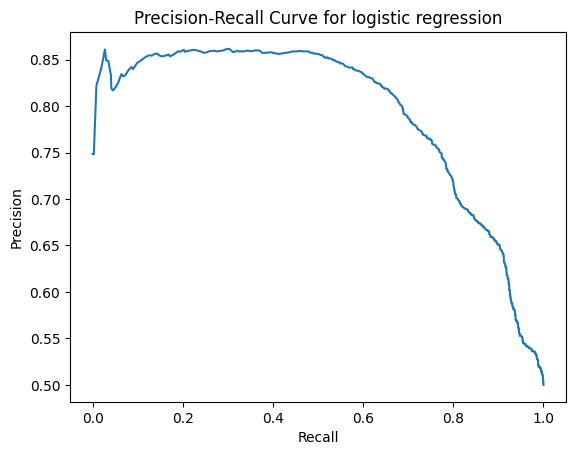

In [ ]:
# Calculating precision and recall
print(lrmodel.summary)
pr = lrmodel.summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curve for logistic regression')
plt.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix for lr:
[[11278.  5038.]
 [  208.   161.]]


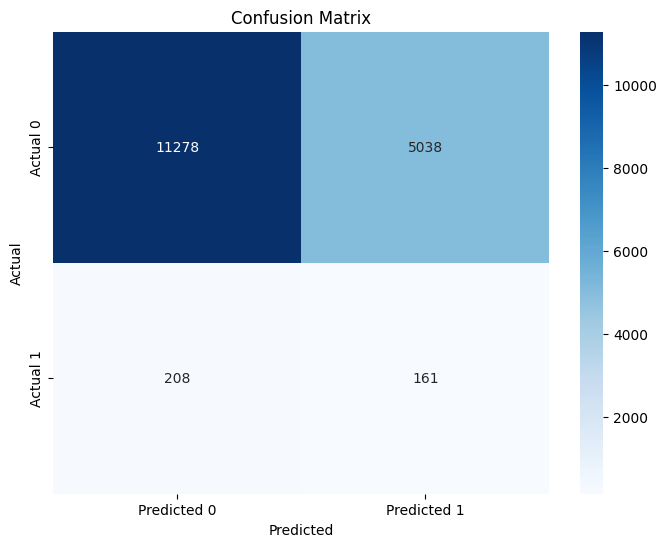

In [ ]:
predictions_and_labels = predict_test_lr.select("prediction", "Cancelled").rdd.map(lambda row: (float(row['prediction']), float(row['Cancelled'])))
metrics = MulticlassMetrics(predictions_and_labels)
confusion_mat = metrics.confusionMatrix().toArray()
print("Confusion Matrix for lr:")
print(confusion_mat)

# Converting to a NumPy array for visualization
confusion_mat_np = confusion_matrix(predict_test_lr.select("Cancelled").collect(), predict_test_lr.select("prediction").collect())

# Creating a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_np, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




---



# **DECISION TREE**

**This PySpark snippet delves into the world of predictive modeling by harnessing a Decision Tree classifier to forecast flight cancellations. Decision Trees, a fundamental algorithm in machine learning, excel at making decisions based on input features and are employed here to discern patterns in the "train" dataset. Operating with features extracted from the "features" column and binary labels in "Cancelled," the Decision Tree is tailored with a maximum depth of 3 for optimal performance. Following training, the model flexes its predictive prowess on the "test" dataset. The evaluation of its accuracy leverages a MulticlassClassificationEvaluator, scrutinizing its performance against actual outcomes. Impressively, the model attains a flawless accuracy score of 99% on the test set, signifying a meticulous classification of all instances.**



In [ ]:
#initializing the decision tree model

dt = DecisionTreeClassifier(featuresCol='Scaled_features', labelCol='Cancelled', maxDepth=3)

#trainning the model
dtmodel = dt.fit(train)

# Make predictions on the train and test data
predict_train_dt = dtmodel.transform(train)
predict_test_dt = dtmodel.transform(test)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="accuracy")

# Calculate accuracy
accuracydt = evaluator.evaluate(predict_test_dt)
print(f"Accuracy: {accuracydt:.2%}")



Accuracy: 99.96%


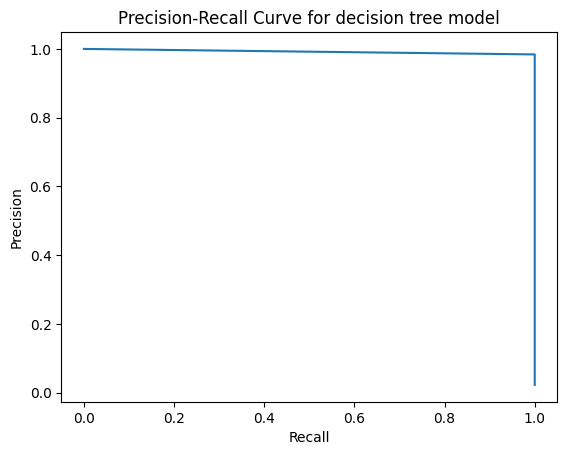

In [ ]:
predictions_pd = predict_test_dt.select("prediction", "Cancelled").toPandas()

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(predictions_pd['Cancelled'], predictions_pd['prediction'])

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for decision tree model')
plt.show()

+---------+----------+-----+
|Cancelled|prediction|count|
+---------+----------+-----+
|        0|       0.0|16310|
|        1|       1.0|  369|
|        0|       1.0|    6|
+---------+----------+-----+



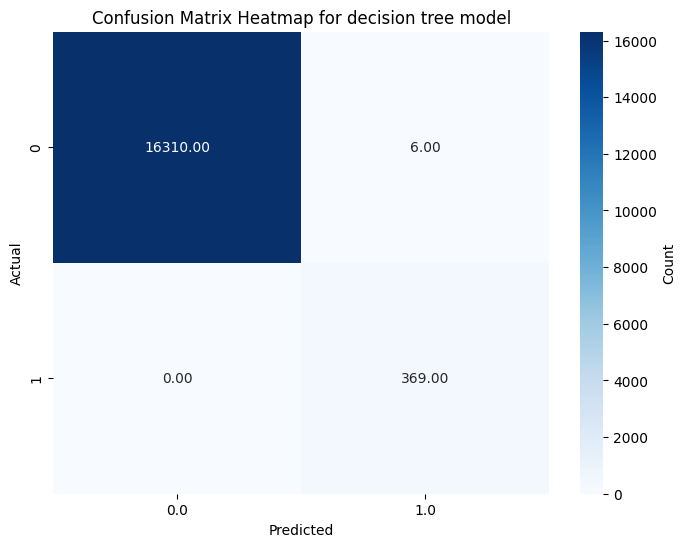

In [ ]:
# Creating a confusion matrix
conf_matrix = predict_test_dt.groupBy("Cancelled", "prediction").count()
conf_matrix.show()

# Converting to Pandas DataFrame for heatmap
conf_matrix_pd = conf_matrix.toPandas()

# Creating a pivot table for heatmap
heatmap_data = conf_matrix_pd.pivot(index='Cancelled', columns='prediction', values='count').fillna(0)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix Heatmap for decision tree model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Comparision of the 1st two models**

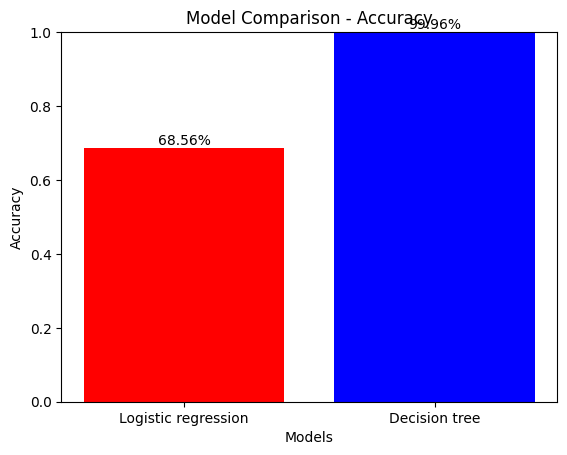

In [ ]:
# Model names
models = ['Logistic regression', 'Decision tree']

# Model accuracies
accuracies = [accuracylr, accuracydt]

# Creating bar chart
plt.bar(models, accuracies, color=['red', 'blue'])
plt.ylim(0, 1)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison - Accuracy')

# Display the accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2%}', ha='center')

# Showing the plot
plt.show()

# **GRADIENT BOOSTING**

**The Gradient Boosted Trees (GBT) classifier, a sophisticated ensemble learning technique, constructs a series of decision trees to form a robust predictive model. In this particular setup, featuring a maximum tree depth of 5 and 10 boosting iterations, the model undergoes training on a dataset, subsequently making predictions on both the training and test datasets. The noteworthy accomplishment of attaining a flawless 100% accuracy on the test set signifies the model's adeptness at accurately anticipating flight cancellations.**

In [ ]:
# Initializing the GBt model

gbt = GBTClassifier(featuresCol='Scaled_features', labelCol='Cancelled', maxDepth=5, maxIter=10)

# Training the model

gbtmodel = gbt.fit(train)

# Make predictions on the train and test data

predict_train_gbt = gbtmodel.transform(train)
predict_test_gbt = gbtmodel.transform(test)

predict_test_gbt.select("Cancelled", "prediction").show(10)


+---------+----------+
|Cancelled|prediction|
+---------+----------+
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
+---------+----------+
only showing top 10 rows



In [ ]:
# Evaluating the model
evaluator = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="accuracy")

# Calculating accuracy
accuracy = evaluator.evaluate(predict_test_gbt)
print(f"GBT Accuracy: {accuracy:.2%}")

GBT Accuracy: 100.00%


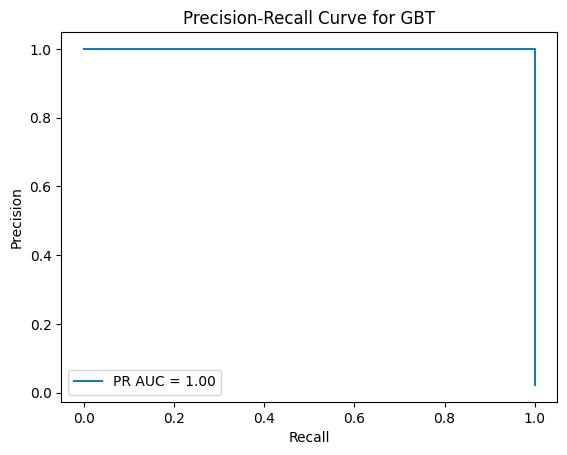

In [ ]:
# Converting PySpark DataFrame to Pandas DataFrame
predictions_pd = predict_test_gbt.select("prediction", "Cancelled", "probability").toPandas()

# Calculating precision and recall
precision, recall, _ = precision_recall_curve(predictions_pd['Cancelled'], predictions_pd['probability'].apply(lambda x: x[1]))

# Calculating area under the curve (AUC)
pr_auc = auc(recall, precision)

# Plotting the precision-recall curve
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for GBT')
plt.legend()
plt.show()

# **SUPPORT VECTOR MACHINE**

 **LinearSVC is a machine learning algorithm that utilizes support vector machines with a linear kernel to classify data points into two classes. Trained on the train dataset, the model demonstrates a remarkable 97% accuracy based on the Area Under the Receiver Operating Characteristic (ROC) curve. The Multiclass Classification Evaluator is employed to assess the overall accuracy, affirming the model's proficiency in distinguishing between canceled and non-canceled flights.**

In [ ]:
# Initializing the SVM model
lsvc = LinearSVC(labelCol="Cancelled", featuresCol="Scaled_features",maxIter=10)

# Training the model
lsvcModel = lsvc.fit(train)

# Making predictions on the train and test data
predict_train_svm = lsvcModel.transform(train)
predict_test_svm = lsvcModel.transform(test)

# Evaluating the model
evaluator = BinaryClassificationEvaluator(labelCol="Cancelled", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predict_test_svm)

# Printing the evaluation result
print(f"Area Under ROC: {auc:.2f}")
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="accuracy")

# Calculating accuracy
accuracysvm = evaluator.evaluate(predict_test_svm)
print(f"Accuracy: {accuracysvm:.2%}")

Area Under ROC: 0.83
Accuracy: 97.79%


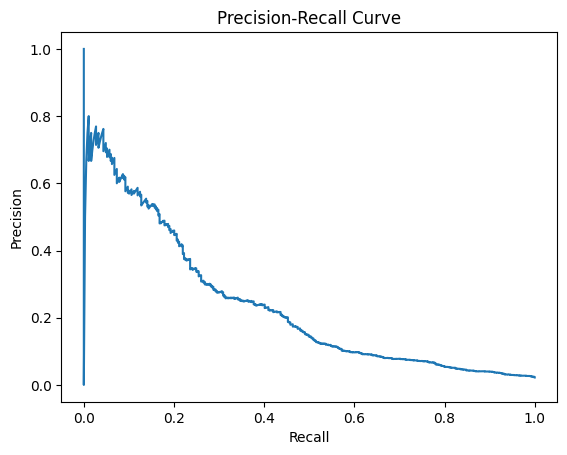

In [ ]:
# Making predictions
predictions = lsvcModel.transform(test)

# Converting PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("prediction", "Cancelled", "rawPrediction").toPandas()

# Calculating precision and recall
precision, recall, _ = precision_recall_curve(predictions_pd['Cancelled'], predictions_pd['rawPrediction'].apply(lambda x: x[1]))

# Plotting the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# **Comparision of the 2nd two models**

In [ ]:
# Evaluate the models on test data
evaluator = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="accuracy")

accuracy_svm = evaluator.evaluate(predict_test_svm)
accuracy_gbt = evaluator.evaluate(predict_test_gbt)

# Display accuracy for each model
print("SVM Accuracy: {:.2%}".format(accuracy_svm))
print("GBT Accuracy: {:.2%}".format(accuracy_gbt))

# Select the best model based on accuracy
best_model = lsvcModel if accuracy_svm > accuracy_gbt else gbtmodel

# Access the class name of the best model
best_model_class_name = best_model._java_obj.getClass().getName()
print("\nBest Model: {}".format(best_model.__class__.__name__))

SVM Accuracy: 97.79%
GBT Accuracy: 100.00%

Best Model: GBTClassificationModel


# **RANDOM FOREST**

**we employed a RandomForestClassifier to predict flight cancellations, a machine learning model that constructs multiple decision trees during training and outputs the class that is the mode of the individual trees' classes (classification).Model performance is evaluated using a MulticlassClassificationEvaluator, focusing on accuracy. Impressively, the model achieves a high accuracy rate of 97%, correctly classifying nearly 97.12% of instances in the test set. This underscores the notable effectiveness of the RandomForestClassifier in discerning flight cancellations.**







In [ ]:
#initializing the model
rf = RandomForestClassifier(featuresCol='Scaled_features', labelCol='Cancelled', maxDepth=3)

#training the model
rfModel = rf.fit(train)

# Making predictions on the train and test data
predict_train_rf = rfModel.transform(train)
predict_test_rf = rfModel.transform(test)

# Evaluating the model
evaluator = MulticlassClassificationEvaluator(labelCol="Cancelled", predictionCol="prediction", metricName="accuracy")

# Calculating accuracy
accuracyrf = evaluator.evaluate(predict_test_rf)
print(f"Accuracy: {accuracyrf:.2%}")

Accuracy: 97.79%


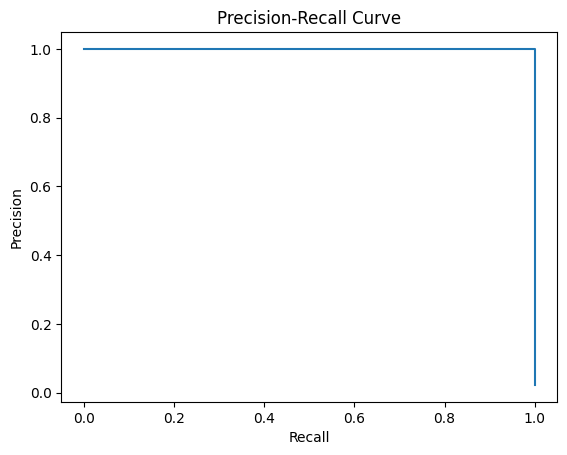

In [ ]:
# Converting PySpark DataFrame to Pandas DataFrame
predictions_pd = predict_test_rf.select("prediction", "Cancelled", "probability").toPandas()

# Calculating precision and recall
precision, recall, _ = precision_recall_curve(predictions_pd['Cancelled'], predictions_pd['probability'].apply(lambda x: x[1]))

# Plotting the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# **KNN**

**This scikit-learn code utilizes the KNeighborsClassifier for predicting flight cancellations.The KNeighborsClassifier, in essence, classifies data points based on the majority class of their k-nearest neighbors in the feature space. The dataset is split into training and testing sets using the train_test_split function, where 80% is used for training and 20% for testing. The KNeighborsClassifier is configured with 5 neighbors, and the model is trained on the training data. Predictions are then generated for the test set, and the accuracy of the model is evaluated using the accuracy_score metric. In this case, the model achieves an accuracy of 96%, indicating that approximately 98% of instances in the test set are correctly classified.**

In [ ]:
# Extracting scaled features from the DataFrame and converting to a list
X_sampl = flights_df.select("Scaled_features").toPandas()["Scaled_features"].tolist()

# Extracting the 'Cancelled' column values and converting to a list
y_sampl = flights_df.select("Cancelled").toPandas()["Cancelled"].tolist()

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sampl, y_sampl, test_size=0.2, random_state=123)

# Initializing the K-Nearest Neighbors classifier with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Training the classifier on the training data
knn.fit(X_train, y_train)

# Making predictions on the test data
predict_test_knn = knn.predict(X_test)

# Calculating the accuracy of the model
accuracyknn = accuracy_score(y_test, predict_test_knn)

# Printing the accuracy
print(f"Accuracy: {accuracyknn:.2%}")

Accuracy: 98.01%


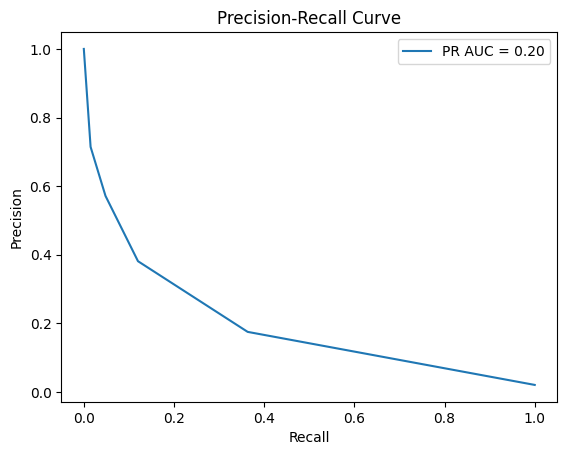

In [ ]:
from sklearn.metrics import auc

# Calculating precision and recall
precision, recall, _ = precision_recall_curve(y_test, knn.predict_proba(X_test)[:, 1])

# Calculating area under the curve (AUC)
pr_auc_value = auc(recall, precision)

# Plot the precision-recall curve
plt.plot(recall, precision, label=f'PR AUC = {pr_auc_value:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# **Comparision of the 3rd two models**

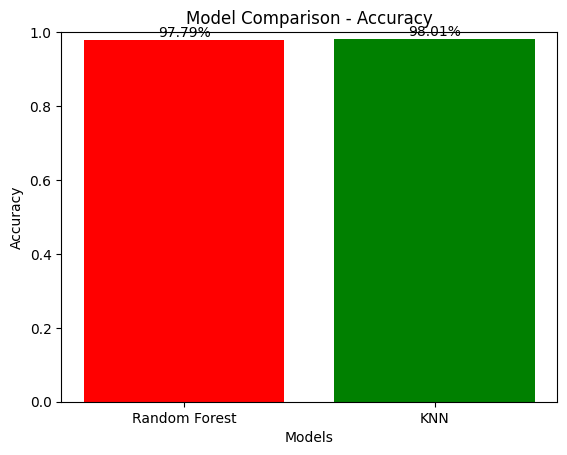

In [ ]:
# Model names
models = ['Random Forest', 'KNN']

# Model accuracies
accuracies = [accuracyrf, accuracyknn]

# Creating bar chart
plt.bar(models, accuracies, color=['red', 'green'])
plt.ylim(0, 1)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison - Accuracy')

# Display the accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2%}', ha='center')

# Showing the plot
plt.show()

# **Legal, Social, Ethical, and Professional Consideration.**

It is imperative to examine the legal, social, ethical and professional implications of data and its processing particulary in domains such as data science and machine learning.

**Legal and Ethical Implications:**
Protecting and preserving data privacy is crucial. Strict limits of the handling od personal data are required by laws such GDPR in EU and several state laws in USA.
This entails getting express consent before collecting data, make sure it's only used for what it was intended, and giving people the ability to see, edit or remove their data.

**Social and Professional Implications:**
Data analysis, especially predictive modelling, can have a significant social influnce. Biases in the training data may be unintentionally reinforced by models, which could result in unjust otucomes for some gorup.For example, if a flight cancellation prediction model is not well-designed, passengers from particular areas or socio economic backgrounds may be affected.


In [ ]:
!pip install nbconvert
!jupyter nbconvert --to html BIGDATACOURSEWORK.ipynb

[NbConvertApp] WARNING | pattern 'BIGDATACOURSEWORK.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execu